Below is a little challenge for you. Your task is to build a model for a segmentation task. The [dataset](https://zenodo.org/record/1154821/) you use is about *Learning Aerial Image Segmentation From Online Maps*

## Download the dataset 

The following lines download the dataset. You could also add other cities from the dataset to your training pipeline.

In [7]:
!pip install --upgrade keras

Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.3.1)


In [2]:
 # Download an unzip the dataset first 
!wget https://zenodo.org/record/1154821/files/berlin.zip
!unzip berlin.zip

--2020-04-13 12:55:51--  https://zenodo.org/record/1154821/files/berlin.zip
Resolving zenodo.org (zenodo.org)... 188.184.117.155
Connecting to zenodo.org (zenodo.org)|188.184.117.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2004638627 (1.9G) [application/octet-stream]
Saving to: ‘berlin.zip’

berlin.zip          100%[===================>]   1.87G  13.8MB/s    in 2m 0s   

2020-04-13 12:57:52 (15.9 MB/s) - ‘berlin.zip’ saved [2004638627/2004638627]

Archive:  berlin.zip
   creating: berlin/
  inflating: berlin/berlin112_image.png  
  inflating: berlin/berlin86_image.png  
  inflating: berlin/berlin28_image.png  
  inflating: berlin/berlin127_image.png  
  inflating: berlin/berlin103_image.png  
  inflating: berlin/berlin27_image.png  
  inflating: berlin/berlin4_image.png  
  inflating: berlin/berlin161_image.png  
  inflating: berlin/berlin174_image.png  
  inflating: berlin/berlin141_image.png  
  inflating: berlin/berlin84_image.png  
  inflating: ber

In [25]:
!pwd

/content


visualize key statistics about the images and masks and show us that you understand the underlying problem. 

implement a function which opens an image file and displays the associated mask as an overlay. 

```python
def overlay(image, mask, alpha=1):
  """
  Args:
      image (string): path to image file 
      mask (string): path to mask file 
      alpha (float): value between 0 and 1 specifying alpha
  """
````
The result of your function should look similar to the image below:

In [0]:
import cv2
import matplotlib.image as mimg
from matplotlib import pyplot

In [0]:
def overlay(image, mask, alpha=1):
  """
  Args:
      image (string): path to image file 
      mask (string): path to mask file 
      alpha (float): value between 0 and 1 specifying alpha
  """
  np_image = mimg.imread(image)
  np_mask = mimg.imread(mask)
  #src2 = cv2.resize(src2, src1.shape[1::-1])
  dst = cv2.addWeighted(np_image,alpha, np_mask, alpha, 0)
  print(dst.shape)
  pyplot.figure()
  pyplot.imshow(dst) 
  pyplot.show()  # display

(2453, 2611, 3)


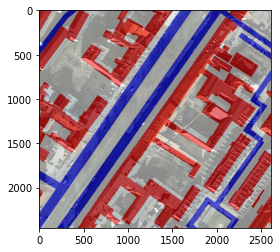

In [78]:
# Example overlay with alpha 50%
image_file = 'berlin/berlin98_image.png'
mask_file = 'berlin/berlin98_labels.png'
overlay(image_file, mask_file, alpha=0.5)

Now train a segmentation model to segment buildings and roads from the dataset. You can use any architecture which you find suitable.

In [0]:
import glob 
img_file_list = sorted(glob.glob('berlin/*_image.png'))
train_img_list, val_img_list =  img_file_list[0:190],img_file_list[190:200]
train_img_list.remove('berlin/berlin100_image.png')# to be used for testing

In [7]:
train_img_list[0:5]

['berlin/berlin101_image.png',
 'berlin/berlin102_image.png',
 'berlin/berlin103_image.png',
 'berlin/berlin104_image.png',
 'berlin/berlin105_image.png']

In [17]:
from keras.models import *
from keras.layers import *
from keras import optimizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [0]:
import numpy as np
label_codes = [(0,0,255),(255,0,0),(255,255,255)]
code2id = {v:k for k,v in enumerate(label_codes)}
id2code = {k:v for k,v in enumerate(label_codes)}

def rgb_to_onehot(rgb_image, colormap = id2code):
    '''Function to one hot encode RGB mask labels
        Inputs: 
            rgb_image - image matrix (eg. 256 x 256 x 3 dimension numpy ndarray)
            colormap - dictionary of color to label id
        Output: One hot encoded image of dimensions (height x width x num_classes) where num_classes = len(colormap)
    '''
    num_classes = len(colormap)
    shape = rgb_image.shape[:2]+(num_classes,)
    encoded_image = np.zeros( shape, dtype=np.int8 )
    for i, cls in enumerate(colormap):
        encoded_image[:,:,i] = np.all(rgb_image.reshape( (-1,3) ) == colormap[i], axis=1).reshape(shape[:2])
    return encoded_image


def onehot_to_rgb(onehot, colormap = id2code):
    '''Function to decode encoded mask labels
        Inputs: 
            onehot - one hot encoded image matrix (height x width x num_classes)
            colormap - dictionary of color to label id
        Output: Decoded RGB image (height x width x 3) 
    '''
    single_layer = np.argmax(onehot, axis=-1)
    output = np.zeros( onehot.shape[:2]+(3,) )
    for k in colormap.keys():
        output[single_layer==k] = colormap[k]
    return np.uint8(output)

In [0]:
def generator(sample_list,filepath, batch_size):
    """
    Function to generate images based on the sample list of files provided and batch size.
    """
    num_samples = len(sample_list)
    c = 0
    print('h')
    while True:
        for offset in range(c,batch_size+c):
            # Initialise X_train and y_train arrays for this batch
            X_train = []
            y_train = []
            val = sample_list[c].split('_')
            folder = val[0]+'_v2'
            x = cv2.imread(filepath+sample_list[c].replace('berlin/',''))
            size = x.shape
            x = cv2.resize(x, ( 512 , 512 ), cv2.INTER_NEAREST)
            x = (x - x.min()) / (x.max() - x.min())
            mask = cv2.imread(filepath + sample_list[c].replace('_image','_labels').replace('berlin/',''))
            size = mask.shape
            y = cv2.resize(mask, ( 512 , 512 ), cv2.INTER_NEAREST)
            mask_encoded = rgb_to_onehot(y, id2code)
            X_train.append(x)
            y_train.append(mask_encoded)
        c+=batch_size
        if(c+batch_size>=num_samples):
            c=0
        X_train = np.array(X_train)
        y_train = np.array(y_train)
        yield X_train, y_train

In [0]:
from keras import backend as K

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f*y_true_f) + K.sum(y_pred_f*y_pred_f) + 1)

In [0]:
def unet(pretrained_weights = None,input_size = (512, 512, 3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    drop5 = Dropout(0.5)(conv3)
    
    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8 = BatchNormalization()(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv10 = Conv2D(3, 1,activation = 'softmax')(conv9)
    model = Model(input = inputs, output = conv10)
    opt = optimizers.SGD(lr=0.01, momentum=0.9, decay=0.01)
    model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics=[dice_coef,'accuracy'])
    #model.summary()
    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [36]:
model = unet('berlin.hdf5')
model_checkpoint = ModelCheckpoint('berlin.hdf5', monitor='accuracy',verbose=1, save_best_only=True)
model.fit_generator(generator(train_img_list,'berlin/',batch_size=20), steps_per_epoch=len(train_img_list)//20, validation_data=generator(val_img_list,'berlin/',batch_size=10),validation_steps=len(val_img_list)//10,
                    nb_epoch=30,callbacks=[model_checkpoint])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., steps_per_epoch=9, validation_data=<generator..., validation_steps=1, callbacks=[<keras.ca..., epochs=30)`
  after removing the cwd from sys.path.


Epoch 1/30h

h
9/9 [==============================] - 109s 12s/step - loss: 0.5178 - dice_coef: 0.8171 - accuracy: 0.7849 - val_loss: 0.7688 - val_dice_coef: 0.7221 - val_accuracy: 0.6676

Epoch 00001: accuracy improved from -inf to 0.78485, saving model to sobha.hdf5
Epoch 2/30
9/9 [==============================] - 96s 11s/step - loss: 0.5126 - dice_coef: 0.8192 - accuracy: 0.7870 - val_loss: 0.7803 - val_dice_coef: 0.7165 - val_accuracy: 0.6612

Epoch 00002: accuracy improved from 0.78485 to 0.78702, saving model to sobha.hdf5
Epoch 3/30
9/9 [==============================] - 97s 11s/step - loss: 0.5014 - dice_coef: 0.8241 - accuracy: 0.7918 - val_loss: 0.7467 - val_dice_coef: 0.7380 - val_accuracy: 0.6862

Epoch 00003: accuracy improved from 0.78702 to 0.79181, saving model to sobha.hdf5
Epoch 4/30
9/9 [==============================] - 99s 11s/step - loss: 0.5113 - dice_coef: 0.8203 - accuracy: 0.7852 - val_loss: 0.8111 - val_dice_coef: 0.7178 - val_accuracy: 0.6561

Epoch 00004: 

The function is able to make predictions on new images. The function takes a model checkpoint and a path to an image as input. The function saves the prediction as a PNG mask. The format has to be identical to the original masks from the training data: 

  - Red color for buildings 
  - Blue color for streets
  - White color for everything else

```python
def predict(model_checkpoint, image_path, out_file):
  """
  Args:
      model_checkpoint (string): path to model checkpoint
      image_path (string): path to an aerial image
      out_file (string): path to save the prediction mask.

  """
```

In [27]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import numpy as np
from matplotlib import image
from matplotlib import pyplot

def predict(model_checkpoint, image_path, out_file):
  """
  Args:
      model_checkpoint (string): path to model checkpoint
      image_path (string): path to an aerial image
      out_file (string): path to save the prediction mask.
 
  """
  model =unet()
  x = cv2.imread(image_path)
  x = cv2.resize(x, ( 512 , 512 ), cv2.INTER_NEAREST) 
  x = np.expand_dims(x,axis=0)
  model.load_weights(model_checkpoint)
  x = (x -x.min())/(x.max()-x.min())
  results = model.predict(x,1,verbose=1)
  result_img = results.squeeze(axis=0)
  y = onehot_to_rgb(result_img,id2code)
  
  img = image.imread('berlin/berlin100_labels.png')
  fig = plt.figure(figsize=(20,8))
  fig.add_subplot(1,2,1)
  plt.imshow(img)
  fig.add_subplot(1,2,2)
  plt.imshow(y)
  plt.show()
  plt.imsave(out_file,y)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


1/1 [==============================] - 3s 3s/step


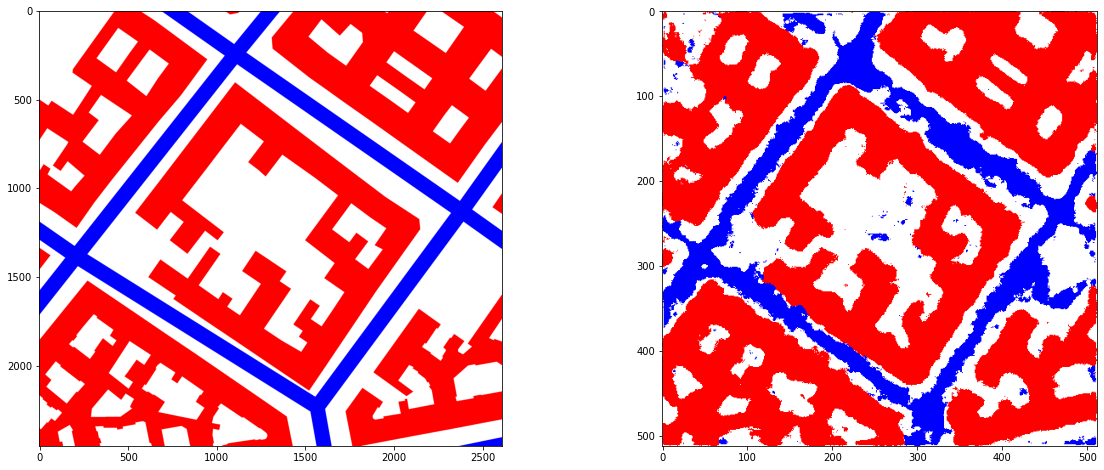

In [65]:
predict('/content/gdrive/My Drive/sobha.hdf5','berlin/berlin100_image.png','berlin/berlin100_result.png')